In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize as imresize
from skimage.color import gray2rgb
from matplotlib import pyplot as plt
from multiprocessing import Pool
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import keras
from keras.models import Model
from keras.layers import Dense
import keras.backend as K
from keras.optimizers import Adam
from keras.applications import VGG16
# from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle as skl_shuffle
from IPython.display import display
K.set_session(session)

DATASET_ROOT = '/hdd/dataset/ML_HW2/CroppedYale/'
SPLIT_P = 35

/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Construct filepaths.
label_name = sorted(next(os.walk(DATASET_ROOT))[1])
CLASS_N = len(label_name)
W, H = 192, 168 # use default imagenet dimensions
EPOCHS = 50
BATCH_SIZE = 16

In [3]:
def read_img(filename):
    img = imread(filename, as_grey=True)
    img = gray2rgb(img)
    if img.shape[0] != H or img.shape[1] != W:
        order = 1 if img.shape[0]<H or img.shape[1]<W else 0
        img = imresize(img, (H,W), order=order, preserve_range=True) # resize
    return img.astype(np.float32)

In [4]:
# Load images and split into train/val sets.
X_train, X_test, Y_train, Y_test = [], [], [], []
for id_, name in tqdm(enumerate(label_name), total=len(label_name)):
    img_paths = glob.glob(DATASET_ROOT+name+'/*.pgm')
    np.random.shuffle(img_paths)
    train_paths, test_paths = img_paths[:SPLIT_P], img_paths[SPLIT_P:]
    X_train.extend([read_img(img_path) for img_path in train_paths])
    Y_train.extend([id_]*len(train_paths))
    X_test.extend([read_img(img_path) for img_path in test_paths])
    Y_test.extend([id_]*len(test_paths))
X_train, X_test, Y_train, Y_test = list(map(np.asarray, [X_train, X_test, Y_train, Y_test]))
# X_train, X_test = list(map(preprocess_input, [X_train, X_test])) # substract mean, etc.
Y_train, Y_test = list(map(lambda x: to_categorical(x, num_classes=CLASS_N), [Y_train, Y_test]))

  0%|          | 0/38 [00:00<?, ?it/s]/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


In [5]:
def make_vgg16(weights=None, fine_tune=False):
    # default initializers of convolution layer in Keras are
    # kernel_initializer='glorot_uniform', bias_initializer='zeros
    model = VGG16(classes=1, include_top=True, input_shape=(H,W,3), weights=None) # random initialization
    if not weights is None:
        model.load_weights(weights, by_name=True)
        if fine_tune:
            for layer in model.layers[:-9]:
                layer.trainable = False # Freeze all pre-trained layers before block4_pool
    out = Dense(CLASS_N, activation='softmax') (model.layers[-3].output) # output layer
    return Model(model.inputs, out)

In [6]:
def plot_loss(history):
    fig, ax = plt.subplots(2, 1, dpi=150)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('model loss')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train','valid'], loc='upper right')
    
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    ax[1].set_title('model accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train','valid'], loc='lower right')
    plt.tight_layout()
    plt.show()

In [7]:
train_generator = ImageDataGenerator(rotation_range=5, width_shift_range=2, zoom_range=0.1, fill_mode='constant', cval=0, horizontal_flip=True, data_format='channels_last')

In [8]:
# default initializers of convolution layer in Keras are
# kernel_initializer='glorot_uniform', bias_initializer='zeros'
vgg16_random = make_vgg16()
vgg16_random.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 168, 192, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 168, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 168, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 84, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 84, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 84, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 42, 48, 128)       0         
__________

Epoch 1/50
84/84 [==============================] - 31s 363ms/step - loss: 3.6586 - acc: 0.0268 - val_loss: 3.6366 - val_acc: 0.0392
Epoch 2/50
84/84 [==============================] - 27s 317ms/step - loss: 3.6346 - acc: 0.0290 - val_loss: 3.6405 - val_acc: 0.0365
Epoch 3/50
84/84 [==============================] - 27s 317ms/step - loss: 3.6277 - acc: 0.0246 - val_loss: 3.6291 - val_acc: 0.0357
Epoch 4/50
84/84 [==============================] - 27s 317ms/step - loss: 3.6241 - acc: 0.0335 - val_loss: 3.6259 - val_acc: 0.0383
Epoch 5/50
84/84 [==============================] - 27s 316ms/step - loss: 3.4801 - acc: 0.0744 - val_loss: 3.1221 - val_acc: 0.1123
Epoch 6/50
84/84 [==============================] - 27s 316ms/step - loss: 2.8475 - acc: 0.2388 - val_loss: 2.1012 - val_acc: 0.3806
Epoch 7/50
84/84 [==============================] - 27s 317ms/step - loss: 1.8112 - acc: 0.4679 - val_loss: 1.4131 - val_acc: 0.5713
Epoch 8/50
84/84 [==============================] - 27s 317ms/step - 

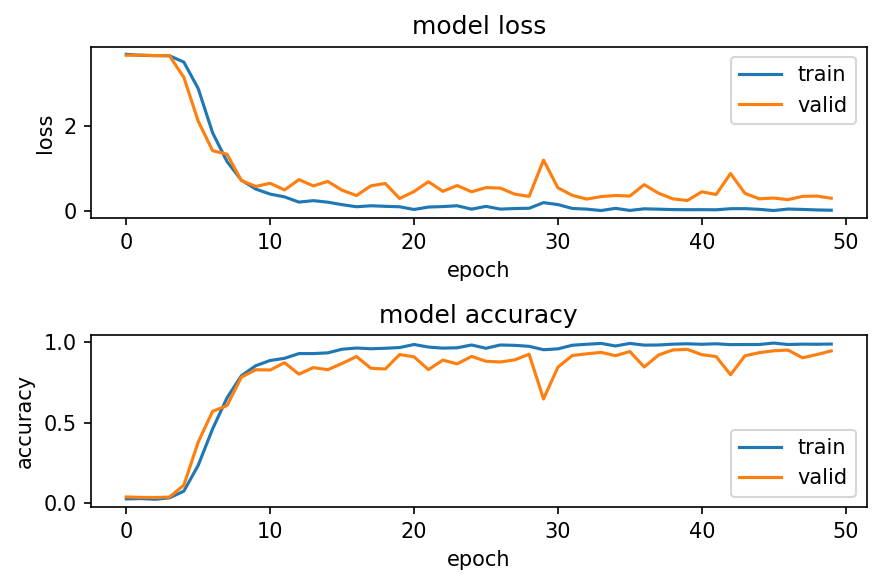

1122/1122 [==============================] - 5s 4ms/step


[0.30629734084938076, 0.946524064171123]

In [9]:
## Train random:
vgg16_random.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
vgg16_random_history = vgg16_random.fit_generator(train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE), validation_data=(X_test, Y_test), epochs=EPOCHS, shuffle=True, workers=3)
plot_loss(vgg16_random_history)
display(vgg16_random.evaluate(X_test, Y_test, batch_size=BATCH_SIZE))
K.clear_session()
del vgg16_random

Epoch 1/50
84/84 [==============================] - 27s 325ms/step - loss: 3.8739 - acc: 0.0238 - val_loss: 3.6025 - val_acc: 0.0455
Epoch 2/50
84/84 [==============================] - 27s 320ms/step - loss: 3.6184 - acc: 0.0402 - val_loss: 3.6316 - val_acc: 0.0428
Epoch 3/50
84/84 [==============================] - 27s 318ms/step - loss: 3.5794 - acc: 0.0506 - val_loss: 3.7029 - val_acc: 0.0472
Epoch 4/50
84/84 [==============================] - 27s 318ms/step - loss: 3.5580 - acc: 0.0573 - val_loss: 3.4927 - val_acc: 0.0446
Epoch 5/50
84/84 [==============================] - 27s 319ms/step - loss: 3.1677 - acc: 0.1153 - val_loss: 2.9265 - val_acc: 0.1845
Epoch 6/50
84/84 [==============================] - 27s 318ms/step - loss: 2.7662 - acc: 0.2135 - val_loss: 2.7580 - val_acc: 0.2424
Epoch 7/50
84/84 [==============================] - 27s 318ms/step - loss: 2.4286 - acc: 0.2917 - val_loss: 2.2652 - val_acc: 0.3369
Epoch 8/50
84/84 [==============================] - 27s 319ms/step - 

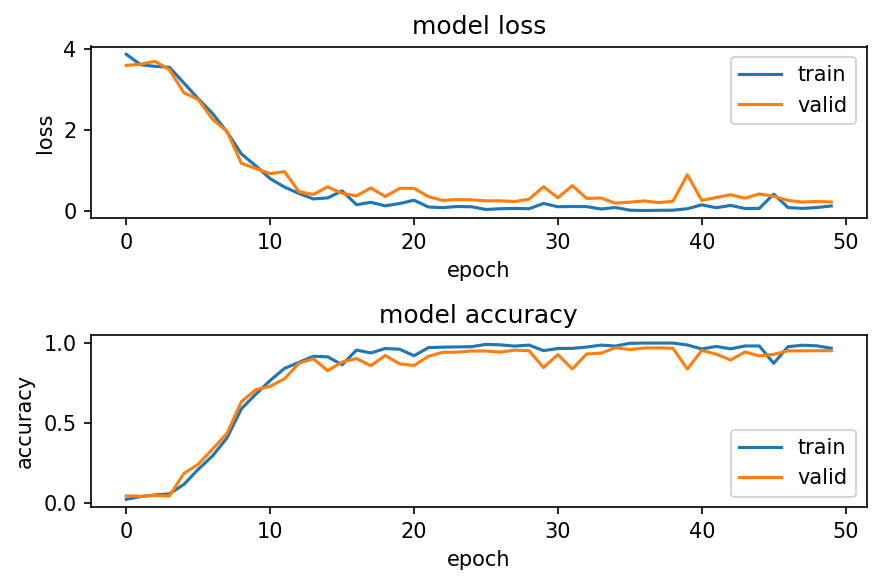

1122/1122 [==============================] - 5s 4ms/step


[0.216275714592769, 0.9500891265597148]

In [10]:
## Train pre-trained:
vgg16_pre_trained = make_vgg16(weights='/hdd/dataset/ML_HW2/model.h5')
vgg16_pre_trained.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
vgg16_pre_trained_history = vgg16_pre_trained.fit_generator(train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE), validation_data=(X_test, Y_test), epochs=EPOCHS, shuffle=True, workers=3)
plot_loss(vgg16_pre_trained_history)
display(vgg16_pre_trained.evaluate(X_test, Y_test, batch_size=BATCH_SIZE))
K.clear_session()
del vgg16_pre_trained

Epoch 1/50
84/84 [==============================] - 17s 197ms/step - loss: 3.9923 - acc: 0.0633 - val_loss: 3.2721 - val_acc: 0.1337
Epoch 2/50
84/84 [==============================] - 16s 194ms/step - loss: 2.6179 - acc: 0.2977 - val_loss: 1.7670 - val_acc: 0.5000
Epoch 3/50
84/84 [==============================] - 16s 191ms/step - loss: 1.5277 - acc: 0.5745 - val_loss: 1.2849 - val_acc: 0.6248
Epoch 4/50
84/84 [==============================] - 16s 193ms/step - loss: 0.8543 - acc: 0.7574 - val_loss: 1.2248 - val_acc: 0.6996
Epoch 5/50
84/84 [==============================] - 16s 192ms/step - loss: 0.5926 - acc: 0.8259 - val_loss: 1.1819 - val_acc: 0.7335
Epoch 6/50
84/84 [==============================] - 16s 194ms/step - loss: 0.5489 - acc: 0.8564 - val_loss: 0.9169 - val_acc: 0.7879
Epoch 7/50
84/84 [==============================] - 16s 194ms/step - loss: 0.4402 - acc: 0.8765 - val_loss: 0.8037 - val_acc: 0.8155
Epoch 8/50
84/84 [==============================] - 16s 194ms/step - 

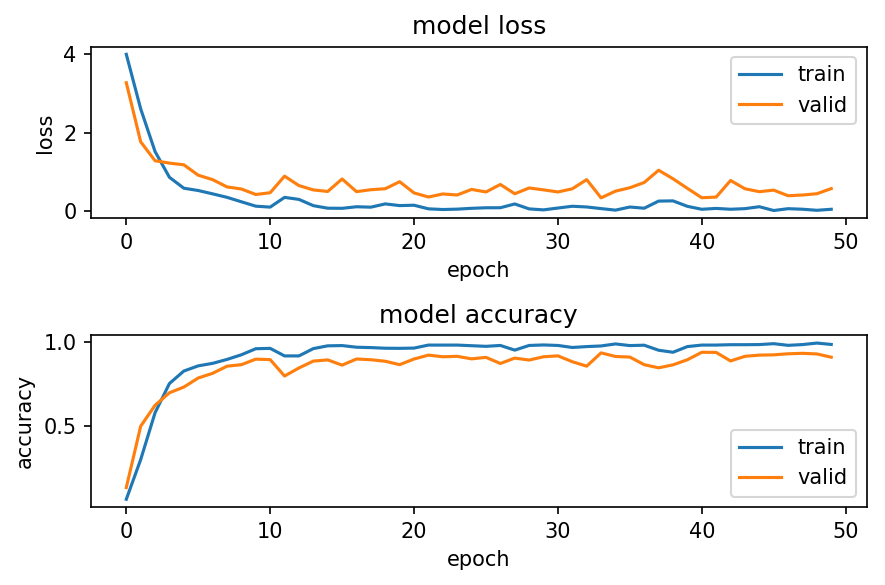

1122/1122 [==============================] - 5s 4ms/step


[0.5755476857645313, 0.9117647058823529]

In [11]:
## Train fine-tune:
vgg16_fine_tune = make_vgg16(weights='/hdd/dataset/ML_HW2/model.h5', fine_tune=True)
vgg16_fine_tune.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
vgg16_fine_tune_history = vgg16_fine_tune.fit_generator(train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE), validation_data=(X_test, Y_test), epochs=EPOCHS, shuffle=True, workers=3)
plot_loss(vgg16_fine_tune_history)
display(vgg16_fine_tune.evaluate(X_test, Y_test, batch_size=BATCH_SIZE))
K.clear_session()
del vgg16_fine_tune